In [1]:
# enrichment and feature ranking
import pandas as pd
from pickle import load
import cobra
import medusa
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [2]:
# load the universal model -- will be needed to get metabolites associated with each reaction
universal = cobra.io.load_json_model('../data/universal_mundy.json')

In [3]:
ensembles = {}
importances = {}
cluster_membership = {}
collapsed_features = {}
# exclude species that had non-variant ensemble structure or predictions.
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia','Achromobacter xylosoxidans','Achromobacter piechaudii']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            print(species_name)
            ensembles[species_name] = load(infile)

        # load the feature importance data for all species
        importances[species_name] = pd.read_csv('../results/classification_results/'+species_name+'_feature_importance.csv',sep=',', index_col = 0)

        # save the cluster membership information
        cluster_membership[species_name] = pd.read_csv('../results/classification_results/'+species_name+'_clusters.csv',sep=',')

        # load the collapsed feature sets
        with open('../results/collapsed_features/'+species_name+'_collapsed_features.json','r') as jsonfile:
            collapsed_features[species_name] = json.load(jsonfile)

Streptococcus equinus
Aeromonas salmonicida
Flavobacterium johnsoniae
Ralstonia solanacearum
Streptococcus mitis
Bacillus pumilus
Enterococcus faecalis
Pseudomonas putida
Haemophilus parasuis
Chryseobacterium gleum
Staphylococcus haemolyticus
Neisseria mucosa
Listeria monocytogenes
Neisseria flavescens
Streptococcus pneumoniae
Haemophilus influenzae
Sphingobacterium spiritivorum
Ralstonia pickettii
Corynebacterium glutamicum
Staphylococcus epidermidis
Pseudomonas mendocina
Streptococcus gallolyticus
Staphylococcus aureus
Streptococcus oralis
Neisseria meningitidis
Corynebacterium efficiens
Streptococcus vestibularis
Pseudomonas stutzeri
Listeria seeligeri


In [4]:
# get the average fractional importance for each reaction.
# first, expand collapsed features and duplicate their fractional importance
reaction_fractional_importances = {}
reaction_fractional_differences = {}
reaction_fractional_ratio = {}
# save the same data to species-specific dictionaries so 
# we can more easily generate species-specific dataframes later
species_fractional_importances = {}
species_fractional_differences = {}
species_fractional_ratio = {}
for species in importances.keys():
    species_fractional_importances[species] = {}
    species_fractional_differences[species] = {}
    species_fractional_ratio[species] = {}
    for reaction in importances[species].index.values:
        # extract all reactions from the collapsed feature set
        subreactions = collapsed_features[species][reaction]
        # if all subreactions are lower bound features, remove the set. This set
        # just represents the lower bound of 0 for all irreversible reactions with a
        # feature.
        if 'upper_bound' in " ".join(subreactions):
            # get rid of upper/lower bound and _c suffix
            subreactions = [r.split('_')[0] for r in subreactions]
            # remove redundant features (upper/lower bound)
            subreactions = list(set(subreactions))

            for r in subreactions:
                # remember: all 'r's get assigned the same importance/difference as the label for the feature set, 'reaction'
                if r in reaction_fractional_importances.keys():
                    reaction_fractional_importances[r].append(importances[species].loc[reaction]['importance'])
                    reaction_fractional_differences[r].append(abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1']))
                    reaction_fractional_ratio[r].append(min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])/
                                                             max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1']))
                else:
                    reaction_fractional_importances[r] = [importances[species].loc[reaction]['importance']]
                    reaction_fractional_differences[r] = [abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1'])]
                    reaction_fractional_ratio[r] = [min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])/
                                                             max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])]
                    



                species_fractional_importances[species][r] = importances[species].loc[reaction]['importance']
                species_fractional_differences[species][r] = abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1'])
                species_fractional_ratio[species][r] = (min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])
                                                             /max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1']))

In [5]:
# Calculate means across the pan-species data
mean_fractional_importances = {r:np.mean(reaction_fractional_importances[r]) for r in reaction_fractional_importances.keys()}
mean_fractional_differences = {r:np.mean(reaction_fractional_differences[r]) for r in reaction_fractional_differences.keys()}
mean_fractional_ratios = {r:np.mean(reaction_fractional_ratio[r]) for r in reaction_fractional_ratio.keys()}
reaction_model_counts = {r:len(reaction_fractional_importances[r]) for r in reaction_fractional_importances.keys()}
zero_weighted_importances = {r:np.sum(reaction_fractional_importances[r])/len(importances.keys()) for r in reaction_fractional_importances.keys()}
zero_weighted_differences = {r:np.sum(reaction_fractional_differences[r])/len(importances.keys()) for r in reaction_fractional_differences.keys()}
for_df = {'mean fractional importance':mean_fractional_importances,
          'mean fractional difference':mean_fractional_differences,
          'zero-weighted importance':zero_weighted_importances,
          'zero-weighted difference':zero_weighted_differences,
          'species count':reaction_model_counts,
          'mean fractional ratio':mean_fractional_ratios}
means_as_df = pd.DataFrame.from_dict(for_df)

species_curation_dfs = {}
for species in species_fractional_importances.keys():
    for_df = {'fractional importance':species_fractional_importances[species],
          'fractional difference':species_fractional_differences[species],
          'fractional ratio':species_fractional_ratio[species]}
    species_curation_dfs[species] = pd.DataFrame.from_dict(for_df)
    
# also calculate mean importances and ratios differences for each metabolite in every reaction
metabolite_importances = {}
metabolite_ratios = {}
for r in reaction_fractional_importances.keys():
    metabolites = universal.reactions.get_by_id(r+'_c').metabolites
    for metabolite in metabolites:
        if metabolite.id in metabolite_importances.keys():
            metabolite_importances[metabolite.id].extend(reaction_fractional_importances[r])
            metabolite_ratios[metabolite.id].extend(reaction_fractional_ratio[r])
        else:
            metabolite_importances[metabolite.id] = reaction_fractional_importances[r]
            metabolite_ratios[metabolite.id] = reaction_fractional_ratio[r]

mean_met_importances = {m:np.mean(metabolite_importances[m]) for m in metabolite_importances.keys()}
mean_met_ratios = {m:np.mean(metabolite_ratios[m]) for m in metabolite_ratios.keys()}
met_rxn_membership_counts = {m:len(metabolite_importances[m]) for m in metabolite_importances.keys()}
met_target_df = pd.DataFrame.from_dict({'mean fractional importance':mean_met_importances,
                                        'mean fractional ratio':mean_met_ratios,
                                        'number of reactions':met_rxn_membership_counts})

In [6]:
# Compile the top 10 curation targets from each species into a single dataframe
# for easier manual searching
i = 0
for species in species_curation_dfs.keys():
    if i == 0:
        df = species_curation_dfs[species].sort_values(by = 'fractional importance', ascending = False).head(10)
        df['species'] = species
    else:
        df2 = species_curation_dfs[species].sort_values(by = 'fractional importance', ascending = False).head(10)
        df2['species'] = species
        df = pd.concat([df,df2])
    i += 1
    
df.to_csv('../results/classification_results/panspecies_top10_targets.csv',sep=',')

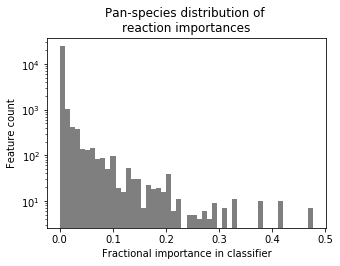

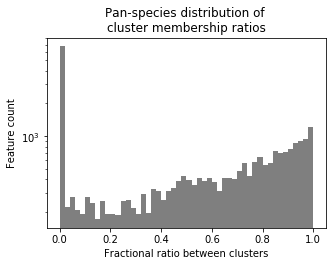

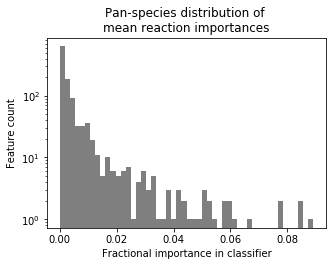

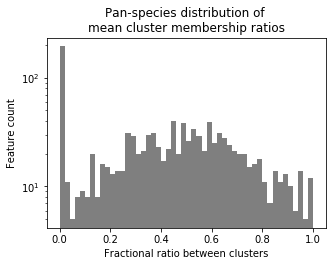

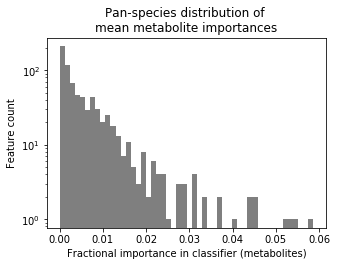

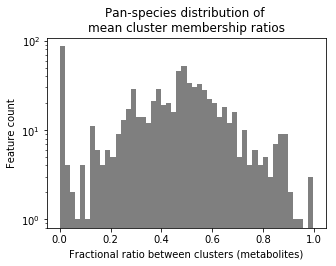

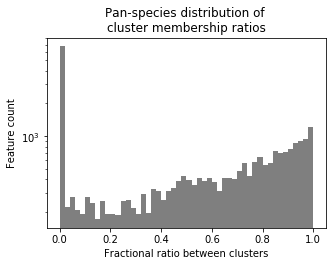

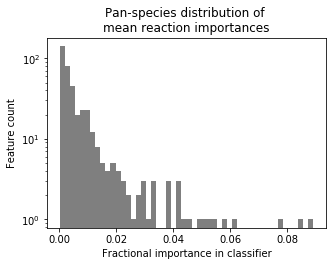

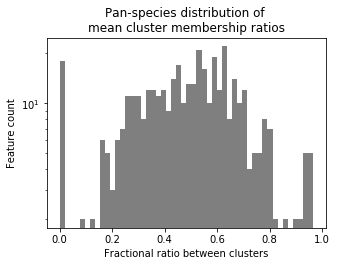

In [7]:
# plot the distribution of fractional importances and fractional ratios across the entire dataset
fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_importances.keys():
    vals.extend(reaction_fractional_importances[r])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
#ax.xaxis.set_major_formatter(mticker.ScalarFormatter()) # <- neither of this get rid of log notation...
#ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

ax.set_title('Pan-species distribution of \nreaction importances')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/feature_importance_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/feature_importance_distribution_SEED.png')

fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_ratio.keys():
    vals.extend(reaction_fractional_ratio[r])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional ratio between clusters')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \ncluster membership ratios')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.png')


## Plot means for reactions

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_importances.keys():
    vals.extend([mean_fractional_importances[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean reaction importances')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/reaction_mean_importance_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_importance_distribution_SEED.png')

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_ratios.keys():
    vals.extend([mean_fractional_ratios[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional ratio between clusters')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean cluster membership ratios')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/reaction_mean_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_ratio_distribution_SEED.png')

## Plot means for metabolites -- raw values will be the exact same distribution 
# as for reactions (verified), so not needed.

fig,ax = plt.subplots()
vals = []
for m in mean_met_importances.keys():
    vals.extend([mean_met_importances[m]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier (metabolites)')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean metabolite importances')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/metabolite_importance_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/metabolite_importance_distribution_SEED.png')

fig,ax = plt.subplots()
vals = []
for m in mean_met_ratios.keys():
    vals.extend([mean_met_ratios[m]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional ratio between clusters (metabolites)')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean cluster membership ratios')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/metabolite_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/metabolite_ratio_distribution_SEED.png')


fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_ratio.keys():
    vals.extend(reaction_fractional_ratio[r])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional ratio between clusters')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \ncluster membership ratios')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.png')

## Plot means for reactions, this time filtered by reactions gapfilled for at least 5 species

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_importances.keys():
    if reaction_model_counts[r] > 4:
        vals.extend([mean_fractional_importances[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean reaction importances')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/reaction_mean_importance_5spec_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_importance_5spec_SEED.png')

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_ratios.keys():
    if reaction_model_counts[r] > 4:
        vals.extend([mean_fractional_ratios[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional ratio between clusters')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean cluster membership ratios')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/reaction_mean_ratio_5spec_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_ratio_5spec_SEED.png')


In [8]:
sorted_df = means_as_df.sort_values(by=['mean fractional ratio','mean fractional importance'], ascending=[True,False])
#sorted_df = sorted_df.sort_values(by='species count', ascending=False)
sorted_df.to_csv('../results/classification_results/panspecies_importances_ratios_means.csv', sep=',')

In [9]:
sorted_met_df = met_target_df.sort_values(by=['mean fractional ratio','mean fractional importance'], ascending=[True,False])
sorted_met_df.to_csv('../results/classification_results/panspecies_metabolite_means.csv', sep=',')

In [10]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


def scatter_curation_targets(df,xvar,yvar,fname,sizevar=None,title=None):
    fig,ax = plt.subplots()

    x = df[xvar].values
    y = df[yvar].values
    
    if sizevar:
        s = df[sizevar].values*10
    else:
        s = 100
    
    ax.scatter(x,y,s=s, alpha = 0.3, color = 'black')
    ax.set_xlim((0,max(x)))
    ax.set_ylim((0,max(y)))
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    ax.set_title(title)
    fig.set_size_inches(5,3.5)
    fig.savefig(fname)
    return ax

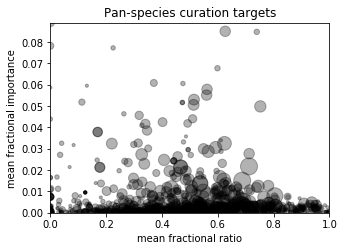

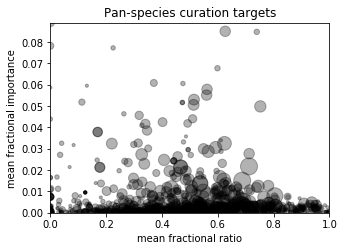

In [11]:
xvar = 'mean fractional ratio'
yvar = 'mean fractional importance'
df = sorted_df
sizevar = 'species count'
fname = '../results/curation_target_plots/panspecies.svg'
all_ax = scatter_curation_targets(sorted_df,xvar,yvar,fname,sizevar,title='Pan-species curation targets')
fname = '../results/curation_target_plots/panspecies.png'
all_ax = scatter_curation_targets(sorted_df,xvar,yvar,fname,sizevar,title='Pan-species curation targets')

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


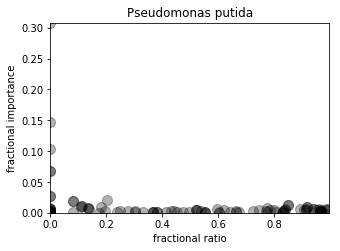

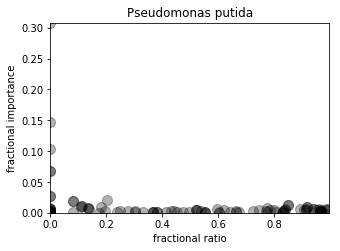

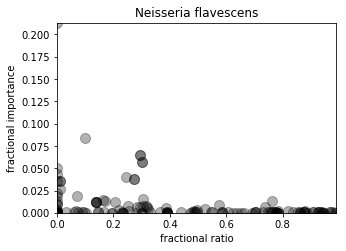

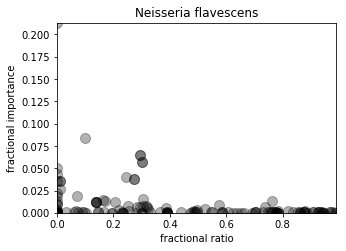

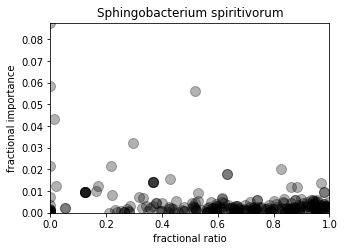

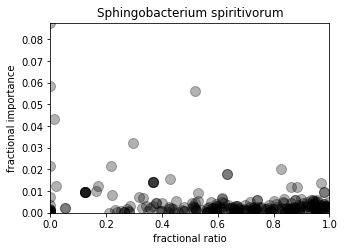

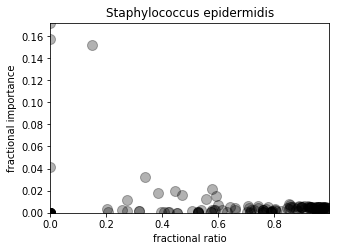

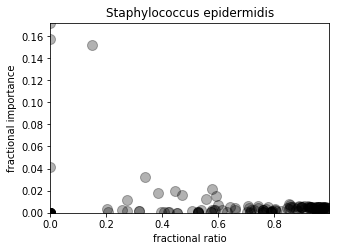

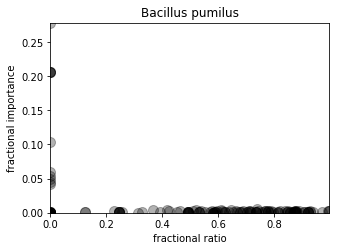

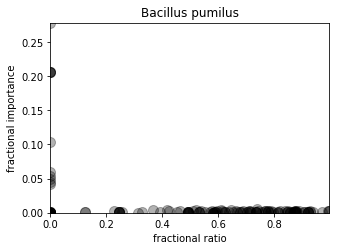

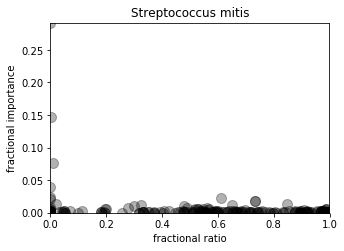

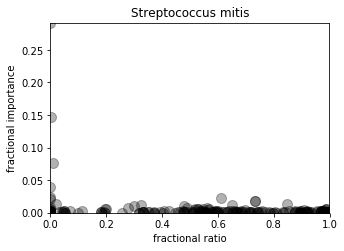

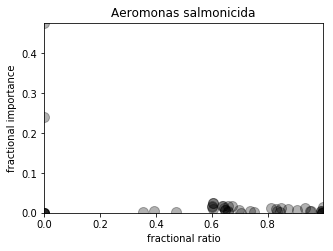

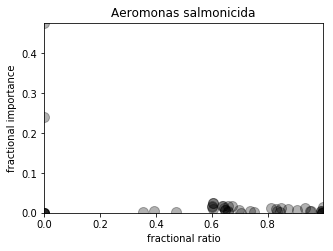

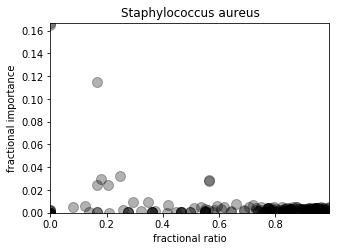

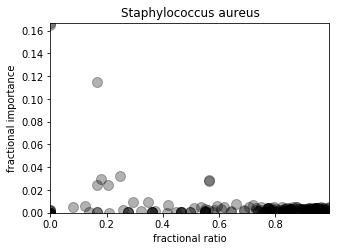

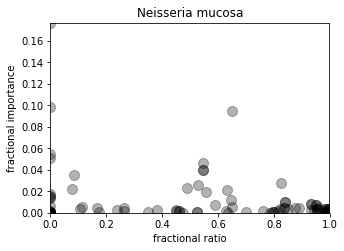

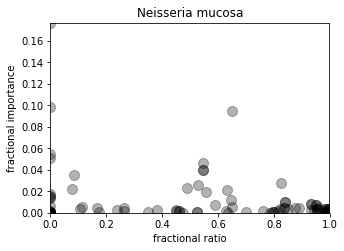

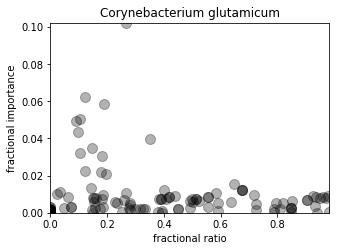

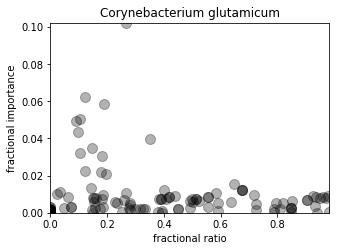

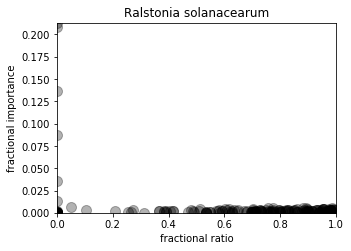

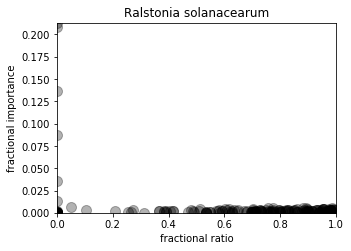

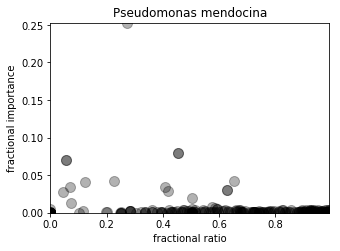

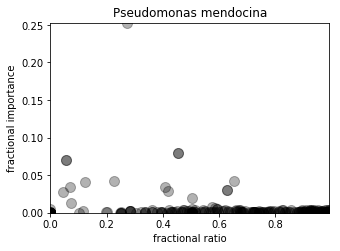

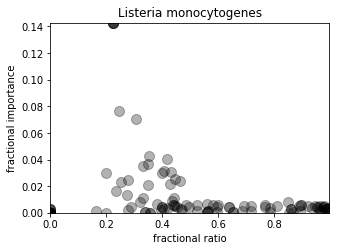

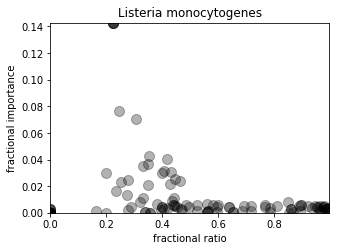

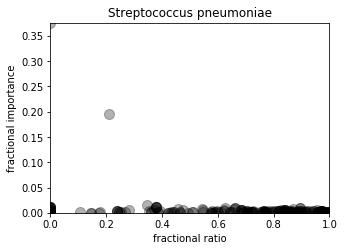

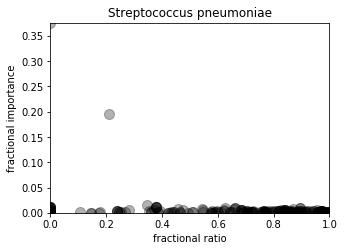

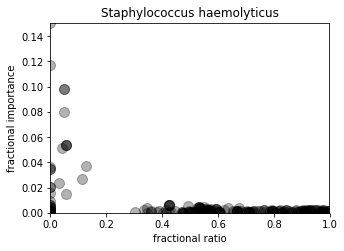

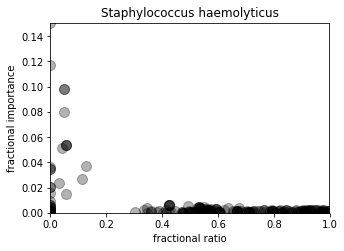

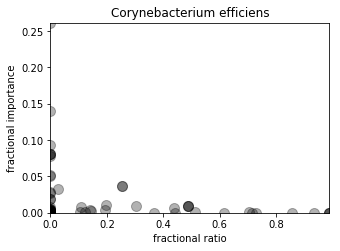

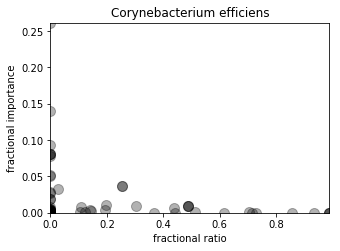

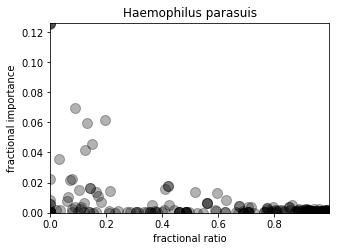

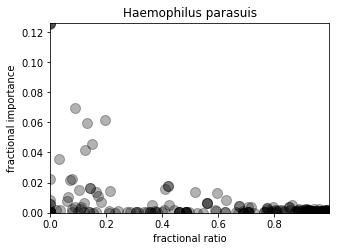

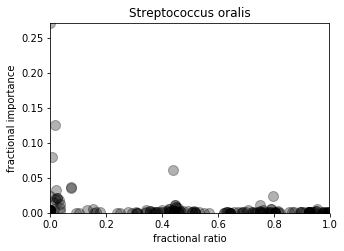

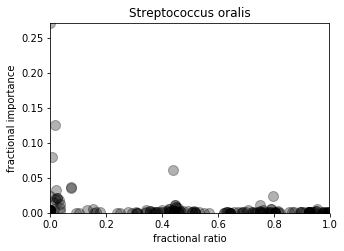

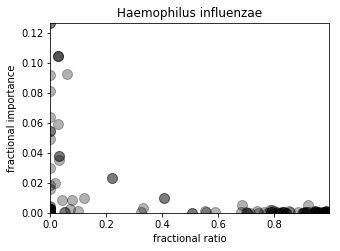

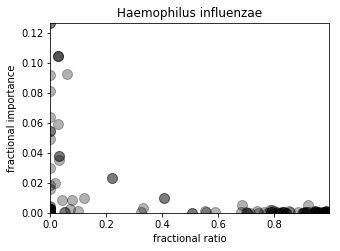

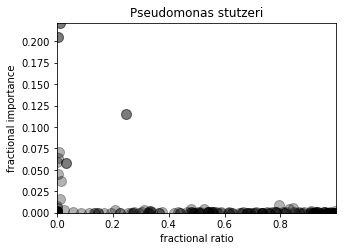

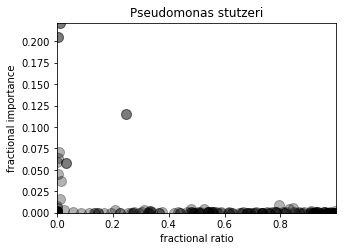

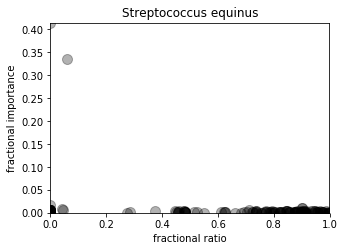

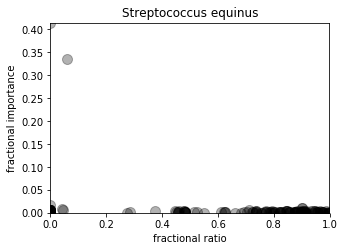

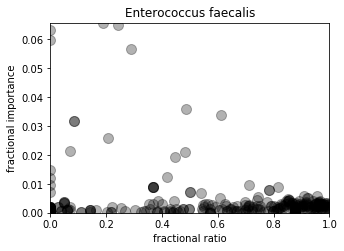

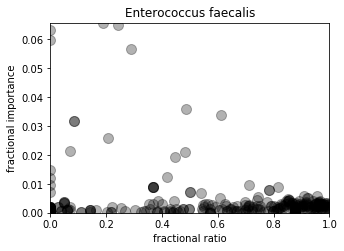

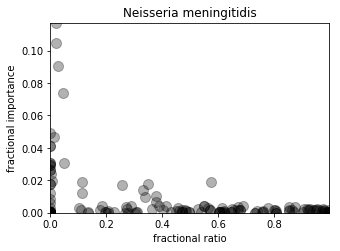

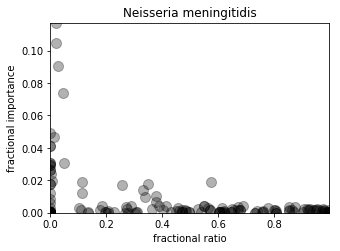

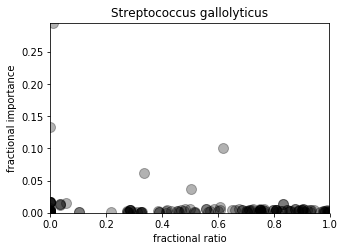

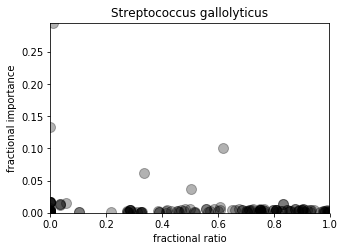

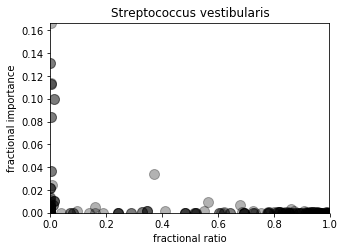

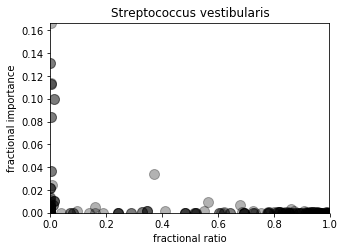

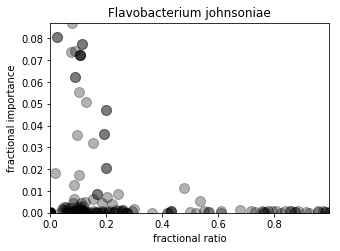

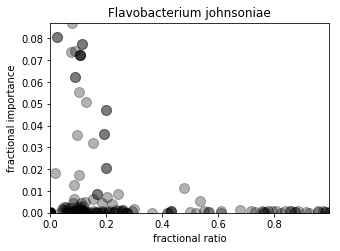

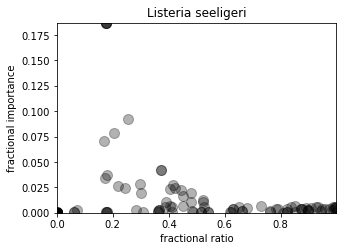

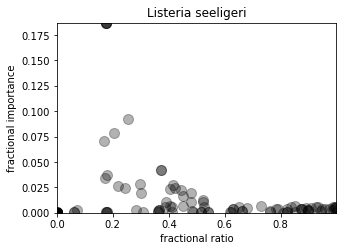

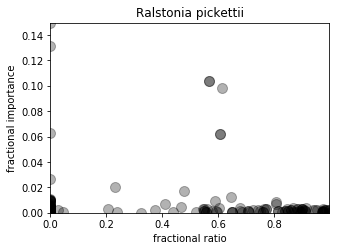

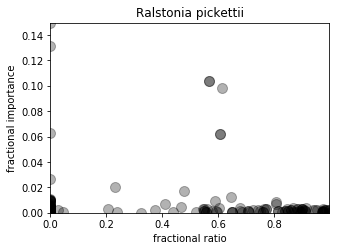

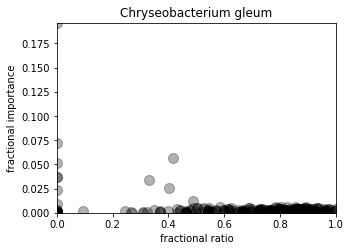

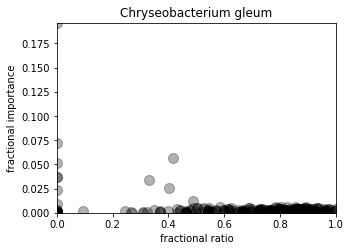

In [12]:
xvar = 'fractional ratio'
yvar = 'fractional importance'
axes = {}
for species in species_curation_dfs.keys():
    
    df = species_curation_dfs[species]
    fname = '../results/curation_target_plots/'+species+'_curation_targets.png'
    axes[species] = scatter_curation_targets(df,xvar,yvar,fname,title=species)
    fname = '../results/curation_target_plots/'+species+'_curation_targets.svg'
    axes[species] = scatter_curation_targets(df,xvar,yvar,fname,title=species)